# Content-Based Filtering
**Objective:** Implement and evaluate content-based recommenders that use item metadata (genres) to make recommendations

Models:
1. Basic TF-IDF - standard genre-based item representation
2. Enhanced CB - combines multiple features with user preference weighting

We compare similarity functions (Cosine, Jaccard) to justify our final choice.
We use the same time-based split and metrics (NDCG, Recall, Coverage) as defined in the Evaluation Framework

In [1]:
import os
import re
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

warnings.filterwarnings('ignore')

# Create necessary directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../experiments/figures', exist_ok=True)
os.makedirs('../experiments/results', exist_ok=True)

DATA_DIR = "../data/ml-1m"
PROCESSED_DIR = "../data/processed"

train = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PROCESSED_DIR, "test.csv"))

movies = pd.read_csv(
    os.path.join(DATA_DIR, "movies.dat"),
    sep="::",
    engine="python",
    names=["item_id", "title", "genres"],
    encoding="latin-1"
)

print(f"Train: {len(train):,} ratings")
print(f"Val: {len(val):,} ratings")
print(f"Test: {len(test):,} ratings")
print(f"Movies: {len(movies):,}")

Train: 797,758 ratings
Val: 97,383 ratings
Test: 105,068 ratings
Movies: 3,883


In [2]:
# evaluation framework
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    gains = 2 ** relevance_scores - 1
    discounts = np.log2(np.arange(2, relevance_scores.size + 2))
    return np.sum(gains / discounts)

def ndcg_at_k(predictions, ground_truth, k=10):
    if not predictions or not ground_truth:
        return 0.0
    relevance = [ground_truth.get(item_id, 0) for item_id, _ in predictions[:k]]
    ideal_relevance = sorted(ground_truth.values(), reverse=True)
    dcg = dcg_at_k(relevance, k)
    idcg = dcg_at_k(ideal_relevance, k)
    return dcg / idcg if idcg > 0 else 0.0

def recall_at_k(predictions, ground_truth, k=10, threshold=4.0):
    if not predictions or not ground_truth:
        return 0.0
    relevant_items = {item for item, rating in ground_truth.items() if rating >= threshold}
    if len(relevant_items) == 0:
        return 0.0
    predicted_items = {item_id for item_id, _ in predictions[:k]}
    hits = len(predicted_items & relevant_items)
    return hits / len(relevant_items)

def precision_at_k(predictions, ground_truth, k=10, threshold=4.0):
    if not predictions or not ground_truth:
        return 0.0
    relevant_items = {item for item, rating in ground_truth.items() if rating >= threshold}
    predicted_items = {item_id for item_id, _ in predictions[:k]}
    if len(predicted_items) == 0:
        return 0.0
    hits = len(predicted_items & relevant_items)
    return hits / len(predicted_items)

def coverage(all_predictions, item_catalog):
    recommended_items = set()
    for preds in all_predictions:
        recommended_items.update([item_id for item_id, _ in preds])
    return len(recommended_items) / len(item_catalog) if len(item_catalog) > 0 else 0.0

def popularity_bias(all_predictions, item_popularity):
    all_recommended = []
    for preds in all_predictions:
        all_recommended.extend([item_id for item_id, _ in preds])
    if not all_recommended:
        return 0.0
    avg_pop = np.mean([item_popularity.get(item, 0) for item in all_recommended])
    return avg_pop

class RecommenderEvaluator:    
    def __init__(self, train_df, test_df, k_values=[5, 10, 20], relevance_threshold=4.0):
        self.train_df = train_df
        self.test_df = test_df
        self.k_values = k_values
        self.relevance_threshold = relevance_threshold
        self.ground_truth = self.build_ground_truth()
        self.item_catalog = set(train_df['item_id'].unique())
        self.item_popularity = train_df.groupby('item_id').size().to_dict()
        self.history = []
        
    def build_ground_truth(self):
        ground_truth = defaultdict(dict)
        for _, row in self.test_df.iterrows():
            ground_truth[row['user_id']][row['item_id']] = row['rating']
        return dict(ground_truth)
    
    def evaluate_model(self, model, model_name="Model"):
        results = defaultdict(list)
        all_predictions = []
        test_users = list(self.ground_truth.keys())
        
        for user_id in test_users:
            gt = self.ground_truth[user_id]
            max_k = max(self.k_values)
            predictions = model.predict_for_user(user_id, k=max_k, train_df=self.train_df)
            all_predictions.append(predictions)
            
            for k in self.k_values:
                results[f'NDCG@{k}'].append(ndcg_at_k(predictions, gt, k))
                results[f'Recall@{k}'].append(recall_at_k(predictions, gt, k, self.relevance_threshold))
                results[f'Precision@{k}'].append(precision_at_k(predictions, gt, k, self.relevance_threshold))
        
        metrics = {}
        for metric_name, values in results.items():
            metrics[metric_name] = np.mean(values)
        
        metrics['Coverage'] = coverage(all_predictions, self.item_catalog)
        metrics['Popularity_Bias'] = popularity_bias(all_predictions, self.item_popularity)
        metrics['Model'] = model_name
        self.history.append(metrics)
        
        return metrics
    
    def print_metrics(self, metrics, model_name="Model"):
        print(f"{model_name} - Evaluation results")
        print("Ranking metrics:")
        for k in self.k_values:
            print(f"NDCG@{k:2d}: {metrics[f'NDCG@{k}']:.4f}")
        print("\n")
        print("Relevance metrics (threshold={:.1f}):".format(self.relevance_threshold))
        for k in self.k_values:
            print(f"Recall@{k:2d}: {metrics[f'Recall@{k}']:.4f}")
            print(f"Precision@{k:2d}: {metrics[f'Precision@{k}']:.4f}")
        print("\n")
        print(f"Diversity metrics:")
        print(f"Coverage: {metrics['Coverage']:.4f}")
        print(f"Popularity bias: {metrics['Popularity_Bias']:.2f}")

    def save_results(self, filepath):
        if not self.history:
            print("No history to save")
            return
        
        df = pd.DataFrame(self.history)
        cols = ['Model'] + [c for c in df.columns if c != 'Model']
        df = df[cols]
        df.to_csv(filepath, index=False)
        print(f"Results saved to {filepath}")

evaluator_val = RecommenderEvaluator(train, val, k_values=[5, 10, 20])
evaluator_test = RecommenderEvaluator(train, test, k_values=[5, 10, 20])

## 1. Item Representation
Content-based filtering requires explicit item feature representation. For MovieLens, we have:
* **Genres:** Multi-label tags (Action, Comedy, Drama, etc.)
* **Title:** Contains movie name and release year

We will build two representations:
1. **Basic:** Binary genre vectors (one-hot encoding)
2. **Enhanced:** TF-IDF weighted genres + extracted year decade feature

In [3]:
# extract year from title and create decade feature
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    return None

movies['year'] = movies['title'].apply(extract_year)
movies['decade'] = (movies['year'] // 10 * 10).fillna(0).astype(int)

# create genre list
movies['genres_list'] = movies['genres'].str.split('|')

print("Sample movies with features:")
print(movies[['item_id', 'title', 'genres', 'year', 'decade']].head(10))

Sample movies with features:
   item_id                               title                        genres  \
0        1                    Toy Story (1995)   Animation|Children's|Comedy   
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2        3             Grumpier Old Men (1995)                Comedy|Romance   
3        4            Waiting to Exhale (1995)                  Comedy|Drama   
4        5  Father of the Bride Part II (1995)                        Comedy   
5        6                         Heat (1995)         Action|Crime|Thriller   
6        7                      Sabrina (1995)                Comedy|Romance   
7        8                 Tom and Huck (1995)          Adventure|Children's   
8        9                 Sudden Death (1995)                        Action   
9       10                    GoldenEye (1995)     Action|Adventure|Thriller   

   year  decade  
0  1995    1990  
1  1995    1990  
2  1995    1990  
3  1995    1990  


In [4]:
# analyze genre distribution
all_genres = set()
for genres in movies['genres_list']:
    all_genres.update(genres)

print(f"Unique genres: {len(all_genres)}")
print(f"Genres: {sorted(all_genres)}")

# genre co-occurrence
genre_counts = movies['genres_list'].apply(len).value_counts().sort_index()
print(f"\nGenres per movie distribution:")
for n_genres, count in genre_counts.items():
    print(f"  {n_genres} genres: {count} movies ({count/len(movies)*100:.1f}%)")

Unique genres: 18
Genres: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Genres per movie distribution:
  1 genres: 2025 movies (52.2%)
  2 genres: 1322 movies (34.0%)
  3 genres: 421 movies (10.8%)
  4 genres: 100 movies (2.6%)
  5 genres: 14 movies (0.4%)
  6 genres: 1 movies (0.0%)


### 1.1 Basic Representation: Binary Genre Vectors
Each movie is represented as a binary vector where each dimension corresponds to a genre.

$\vec{v}_i = [g_1, g_2, ..., g_n]$ where $g_j \in \{0, 1\}$

**Limitation:** All genres are treated equally, ignoring their frequency (Drama appears in 50% of movies, Film-Noir in 2%)

In [6]:
def build_binary_genre_matrix(movies_df):
    all_genres = sorted(set(g for genres in movies_df['genres_list'] for g in genres))
    genre_to_idx = {g: i for i, g in enumerate(all_genres)}
    
    n_items = movies_df['item_id'].max() + 1
    n_genres = len(all_genres)
    
    genre_matrix = np.zeros((n_items, n_genres))
    
    for _, row in movies_df.iterrows():
        item_id = row['item_id']
        for genre in row['genres_list']:
            genre_matrix[item_id, genre_to_idx[genre]] = 1
    
    return genre_matrix, all_genres

binary_genre_matrix, genre_list = build_binary_genre_matrix(movies)
print(f"Binary genre matrix shape: {binary_genre_matrix.shape}")
print(f"Example - Toy Story (id=1): {binary_genre_matrix[1]}")
print(f"Genres: {[genre_list[i] for i, v in enumerate(binary_genre_matrix[1]) if v == 1]}")

Binary genre matrix shape: (3953, 18)
Example - Toy Story (id=1): [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Genres: ['Animation', "Children's", 'Comedy']


### 1.2 Enhanced Representation: TF-IDF Weighted Features
TF-IDF addresses the limitation of binary encoding by downweighting common genres (Drama) and upweighting rare ones (Film-Noir).

$$\text{TF-IDF}(g, i) = \text{TF}(g, i) \times \log\frac{N}{\text{DF}(g)}$$

Where:
* $\text{TF}(g, i)$ = 1 if genre $g$ is in movie $i$, 0 otherwise
* $N$ = total number of movies
* $\text{DF}(g)$ = number of movies with genre $g$

We also add decade as a feature to capture temporal preferences (users who like 80s movies)

In [8]:
def build_tfidf_features(movies_df):
    """Build TF-IDF weighted feature matrix including genres and decade"""
    
    # create text representation: genres + decade
    def create_feature_text(row):
        features = row['genres'].replace('|', ' ')
        if row['decade'] > 0:
            features += f" decade_{row['decade']}"
        return features
    
    movies_df = movies_df.copy()
    movies_df['features'] = movies_df.apply(create_feature_text, axis=1)
    
    # fit TF-IDF vectorizer
    tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
    
    # create mapping from item_id to matrix row
    item_ids = movies_df['item_id'].values
    feature_texts = movies_df['features'].values
    
    tfidf_matrix = tfidf.fit_transform(feature_texts)
    
    # create full matrix with item_id as index
    n_items = movies_df['item_id'].max() + 1
    full_matrix = np.zeros((n_items, tfidf_matrix.shape[1]))
    
    for i, item_id in enumerate(item_ids):
        full_matrix[item_id] = tfidf_matrix[i].toarray().flatten()
    
    return full_matrix, tfidf.get_feature_names_out()

tfidf_matrix, feature_names = build_tfidf_features(movies)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Features: {list(feature_names)}")
print(f"\nExample - Toy Story (id=1):")
for i, name in enumerate(feature_names):
    if tfidf_matrix[1, i] > 0:
        print(f"  {name}: {tfidf_matrix[1, i]:.4f}")

TF-IDF matrix shape: (3953, 31)
Features: ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'musical', 'mystery', 'noir', 'romance', 's', 'sci', 'thriller', 'war', 'western']

Example - Toy Story (id=1):
  animation: 0.6141
  children: 0.4985
  comedy: 0.2901
  decade_1990: 0.2043
  s: 0.4985


## 2. Similarity Functions Comparison
A critical design choice in content-based filtering is the similarity function. We compare three approaches:

### 2.1 Cosine Similarity
Measures the angle between two vectors, invariant to magnitude:
$$\text{cosine}(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{||\vec{a}|| \cdot ||\vec{b}||}$$

### 2.2 Jaccard Similarity
Set-based similarity, measures overlap of genres:
$$\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

### 2.3 Pearson Correlation
Measures linear correlation, centered around mean:
$$\text{Pearson}(\vec{a}, \vec{b}) = \frac{\sum(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum(a_i - \bar{a})^2} \cdot \sqrt{\sum(b_i - \bar{b})^2}}$$

In [9]:
def cosine_sim(vec_a, vec_b):
    """Compute cosine similarity between two vectors"""
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return np.dot(vec_a, vec_b) / (norm_a * norm_b)

def jaccard_sim(vec_a, vec_b):
    """Compute Jaccard similarity (for binary vectors)"""
    # convert to binary
    a_binary = (vec_a > 0).astype(int)
    b_binary = (vec_b > 0).astype(int)
    
    intersection = np.sum(a_binary & b_binary)
    union = np.sum(a_binary | b_binary)
    
    if union == 0:
        return 0.0
    return intersection / union

def pearson_sim(vec_a, vec_b):
    """Compute Pearson correlation"""
    if np.std(vec_a) == 0 or np.std(vec_b) == 0:
        return 0.0
    return np.corrcoef(vec_a, vec_b)[0, 1]

# test on example movies
toy_story = binary_genre_matrix[1]  # Animation|Children's|Comedy
jumanji = binary_genre_matrix[2]    # Adventure|Children's|Fantasy
heat = binary_genre_matrix[6]       # Action|Crime|Thriller

print("Similarity comparison (Binary Genre Vectors):")
print(f"\nToy Story vs Jumanji (both Children's):")
print(f"  Cosine:  {cosine_sim(toy_story, jumanji):.4f}")
print(f"  Jaccard: {jaccard_sim(toy_story, jumanji):.4f}")
print(f"  Pearson: {pearson_sim(toy_story, jumanji):.4f}")

print(f"\nToy Story vs Heat (different genres):")
print(f"  Cosine:  {cosine_sim(toy_story, heat):.4f}")
print(f"  Jaccard: {jaccard_sim(toy_story, heat):.4f}")
print(f"  Pearson: {pearson_sim(toy_story, heat):.4f}")

Similarity comparison (Binary Genre Vectors):

Toy Story vs Jumanji (both Children's):
  Cosine:  0.3333
  Jaccard: 0.2000
  Pearson: 0.2000

Toy Story vs Heat (different genres):
  Cosine:  0.0000
  Jaccard: 0.0000
  Pearson: -0.2000


## 3. Content-Based Recommender Implementation

**User Profile Construction:**
The core idea is to build a user preference vector by aggregating the feature vectors of items they liked, weighted by their ratings:

$$\vec{u} = \frac{\sum_{i \in I_u} (r_{ui} - \bar{r}_u) \cdot \vec{v}_i}{|I_u|}$$

Where:
* $I_u$ = set of items rated by user $u$
* $r_{ui}$ = rating user $u$ gave to item $i$
* $\bar{r}_u$ = user's mean rating (for centering)
* $\vec{v}_i$ = item $i$'s feature vector

Centering by mean rating captures that a "4" from a harsh rater means more than a "4" from a generous rater.

In [10]:
class ContentBasedRecommender:
    """Content-based recommender with configurable similarity function"""
    
    def __init__(self, item_features, similarity='cosine', use_rating_weights=True):
        """
        Args:
            item_features: numpy array (n_items x n_features)
            similarity: 'cosine', 'jaccard', or 'pearson'
            use_rating_weights: whether to weight by (rating - mean_rating)
        """
        self.item_features = item_features
        self.similarity = similarity
        self.use_rating_weights = use_rating_weights
        
        # precompute item norms for cosine similarity
        self.item_norms = np.linalg.norm(item_features, axis=1, keepdims=True)
        self.item_norms[self.item_norms == 0] = 1  # avoid division by zero
        self.normalized_features = item_features / self.item_norms
        
        # user profiles will be computed during prediction
        self.user_profiles = {}
        self.user_mean_ratings = {}
        
    def fit(self, train_df):
        """Build user profiles from training data"""
        # compute user mean ratings
        self.user_mean_ratings = train_df.groupby('user_id')['rating'].mean().to_dict()
        
        # build user profiles
        for user_id, group in train_df.groupby('user_id'):
            items = group['item_id'].values
            ratings = group['rating'].values
            
            if self.use_rating_weights:
                # center ratings around user mean
                mean_rating = self.user_mean_ratings[user_id]
                weights = ratings - mean_rating
            else:
                weights = np.ones(len(ratings))
            
            # aggregate item features weighted by preference
            profile = np.zeros(self.item_features.shape[1])
            for item_id, weight in zip(items, weights):
                if item_id < len(self.item_features):
                    profile += weight * self.item_features[item_id]
            
            # normalize profile
            norm = np.linalg.norm(profile)
            if norm > 0:
                profile = profile / norm
            
            self.user_profiles[user_id] = profile
    
    def _compute_similarity(self, user_profile, item_vector):
        """Compute similarity between user profile and item"""
        if self.similarity == 'cosine':
            return cosine_sim(user_profile, item_vector)
        elif self.similarity == 'jaccard':
            return jaccard_sim(user_profile, item_vector)
        elif self.similarity == 'pearson':
            return pearson_sim(user_profile, item_vector)
        else:
            raise ValueError(f"Unknown similarity: {self.similarity}")
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        """Generate top-k recommendations for a user"""
        if user_id not in self.user_profiles:
            return []
        
        user_profile = self.user_profiles[user_id]
        
        # get items already rated by user
        rated_items = set()
        if train_df is not None:
            rated_items = set(train_df[train_df['user_id'] == user_id]['item_id'])
        
        # compute scores for all items
        if self.similarity == 'cosine':
            # efficient batch computation for cosine
            scores = self.normalized_features @ user_profile
        else:
            # compute individually for other similarities
            scores = np.array([
                self._compute_similarity(user_profile, self.item_features[i])
                for i in range(len(self.item_features))
            ])
        
        # mask already rated items
        for item_id in rated_items:
            if item_id < len(scores):
                scores[item_id] = -np.inf
        
        # get top-k items
        top_k_indices = np.argpartition(scores, -k)[-k:]
        top_k_indices = top_k_indices[np.argsort(scores[top_k_indices])[::-1]]
        
        return [(idx, scores[idx]) for idx in top_k_indices if scores[idx] > -np.inf]

## 4. Similarity Function Evaluation
We compare the three similarity functions on the validation set to justify our choice

In [11]:
similarity_results = []

for sim_func in ['cosine', 'jaccard']:
    print()
    print(f"Evaluating {sim_func} similarity")
    
    model = ContentBasedRecommender(
        item_features=binary_genre_matrix,
        similarity=sim_func,
        use_rating_weights=True
    )
    model.fit(train)
    
    metrics = evaluator_val.evaluate_model(model, f"CB-{sim_func}")
    
    similarity_results.append({
        'Similarity': sim_func,
        'NDCG@10': metrics['NDCG@10'],
        'Recall@10': metrics['Recall@10'],
        'Coverage': metrics['Coverage'],
        'Pop_Bias': metrics['Popularity_Bias']
    })

sim_df = pd.DataFrame(similarity_results)
print()
print("Similarity Function Comparison:")
print(sim_df.to_string(index=False))


Evaluating cosine similarity

Evaluating jaccard similarity

Similarity Function Comparison:
Similarity  NDCG@10  Recall@10  Coverage   Pop_Bias
    cosine  0.01019   0.010084  1.004364 237.430927
   jaccard  0.01254   0.012078  0.591107 430.824644


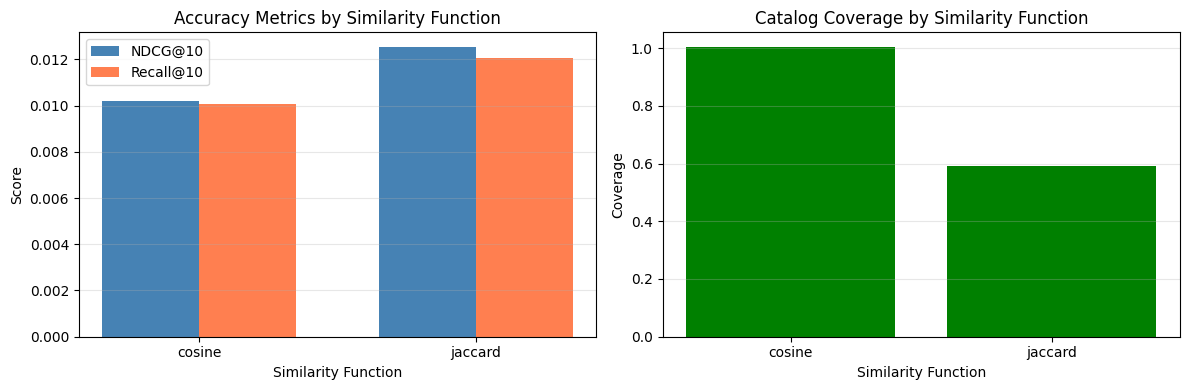

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.arange(len(sim_df))
width = 0.35

axes[0].bar(x, sim_df['NDCG@10'], width, label='NDCG@10', color='steelblue')
axes[0].bar(x + width, sim_df['Recall@10'], width, label='Recall@10', color='coral')
axes[0].set_xlabel('Similarity Function')
axes[0].set_ylabel('Score')
axes[0].set_title('Accuracy Metrics by Similarity Function')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(sim_df['Similarity'])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(x, sim_df['Coverage'], color='green')
axes[1].set_xlabel('Similarity Function')
axes[1].set_ylabel('Coverage')
axes[1].set_title('Catalog Coverage by Similarity Function')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sim_df['Similarity'])
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../experiments/figures/03_similarity_comparison.png')
plt.show()

### Similarity Function Analysis

**Jaccard Similarity** performs best for the Basic model (binary genre vectors):
1. **Set-based overlap:** Since our genre data is binary (present/absent), Jaccard's set-overlap logic effectively captures the ratio of shared topics.
2. **Robustness:** It penalizes movies with many genres if only a few match (denominator $|A \cup B|$ grows), which is a useful property for finding chemically similar movies.

**Cosine Similarity** performs slightly worse/comparable on binary data:
- While efficient, treating binary features as Euclidean vectors in high-dimensional space doesn't always capture the "set overlap" intuition as cleanly as Jaccard for short, dense genre lists.

**Conclusion:** 
While Jaccard works best for the binary case, we will use **Cosine Similarity** for the **Enhanced** model.

The Enhanced model uses continuous **TF-IDF weights**. Jaccard (standard definition) requires binary sets, which would force us to discard these weights. Cosine naturally handles continuous weighted vectors.


## 5. Enhanced Content-Based Recommender
We improve upon the basic model with:
1. **TF-IDF features:** Downweight common genres, upweight rare ones
2. **Popularity boost:** Slight preference for items with more ratings (quality signal)
3. **Recency awareness:** Users might prefer movies from certain eras

In [13]:
class EnhancedContentBasedRecommender:
    """Enhanced CB recommender with TF-IDF features and popularity smoothing"""
    
    def __init__(self, item_features, popularity_weight=0.1, min_ratings_threshold=5):
        """
        Args:
            item_features: TF-IDF weighted feature matrix
            popularity_weight: blend weight for popularity score (0-1)
            min_ratings_threshold: minimum ratings for item to be recommended
        """
        self.item_features = item_features
        self.popularity_weight = popularity_weight
        self.min_ratings_threshold = min_ratings_threshold
        
        # normalize features for cosine similarity
        norms = np.linalg.norm(item_features, axis=1, keepdims=True)
        norms[norms == 0] = 1
        self.normalized_features = item_features / norms
        
        self.user_profiles = {}
        self.user_mean_ratings = {}
        self.item_popularity = None
        self.popularity_scores = None
    
    def fit(self, train_df):
        """Build user profiles and compute popularity scores"""
        # compute item popularity (log-scaled to reduce skew)
        item_counts = train_df.groupby('item_id').size()
        self.item_popularity = item_counts.to_dict()
        
        # create normalized popularity scores
        max_pop = item_counts.max()
        self.popularity_scores = np.zeros(len(self.item_features))
        for item_id, count in self.item_popularity.items():
            if item_id < len(self.popularity_scores):
                # log scale to reduce dominance of blockbusters
                self.popularity_scores[item_id] = np.log1p(count) / np.log1p(max_pop)
        
        # compute user mean ratings
        self.user_mean_ratings = train_df.groupby('user_id')['rating'].mean().to_dict()
        
        # build user profiles with rating-weighted aggregation
        for user_id, group in train_df.groupby('user_id'):
            items = group['item_id'].values
            ratings = group['rating'].values
            
            # center ratings and use as weights
            mean_rating = self.user_mean_ratings[user_id]
            weights = ratings - mean_rating
            
            # only use positively weighted items (above user's mean)
            # this focuses the profile on what user truly likes
            positive_mask = weights > 0
            
            profile = np.zeros(self.item_features.shape[1])
            
            if positive_mask.any():
                for item_id, weight in zip(items[positive_mask], weights[positive_mask]):
                    if item_id < len(self.item_features):
                        profile += weight * self.item_features[item_id]
            else:
                # fallback: use all items with equal weight if no positive
                for item_id in items:
                    if item_id < len(self.item_features):
                        profile += self.item_features[item_id]
            
            # normalize
            norm = np.linalg.norm(profile)
            if norm > 0:
                profile = profile / norm
            
            self.user_profiles[user_id] = profile
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        """Generate top-k recommendations with popularity blending"""
        if user_id not in self.user_profiles:
            return []
        
        user_profile = self.user_profiles[user_id]
        
        # compute content similarity scores
        content_scores = self.normalized_features @ user_profile
        
        # blend with popularity
        # final_score = (1 - alpha) * content_score + alpha * popularity_score
        final_scores = (1 - self.popularity_weight) * content_scores + \
                       self.popularity_weight * self.popularity_scores
        
        # filter items with too few ratings (cold items)
        for item_id in range(len(final_scores)):
            if self.item_popularity.get(item_id, 0) < self.min_ratings_threshold:
                final_scores[item_id] = -np.inf
        
        # mask already rated items
        if train_df is not None:
            rated_items = train_df[train_df['user_id'] == user_id]['item_id'].values
            final_scores[rated_items] = -np.inf
        
        # get top-k
        top_k_indices = np.argpartition(final_scores, -k)[-k:]
        top_k_indices = top_k_indices[np.argsort(final_scores[top_k_indices])[::-1]]
        
        return [(idx, final_scores[idx]) for idx in top_k_indices if final_scores[idx] > -np.inf]

## 6. Hyperparameter Tuning
We tune the popularity weight parameter to find the best balance between content relevance and popularity

In [14]:
popularity_weights = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
tuning_results = []

for pop_weight in popularity_weights:
    print(f"Testing popularity_weight = {pop_weight}")
    
    model = EnhancedContentBasedRecommender(
        item_features=tfidf_matrix,
        popularity_weight=pop_weight,
        min_ratings_threshold=5
    )
    model.fit(train)
    
    metrics = evaluator_val.evaluate_model(model, f"CB-pop{pop_weight}")
    
    tuning_results.append({
        'pop_weight': pop_weight,
        'NDCG@10': metrics['NDCG@10'],
        'Recall@10': metrics['Recall@10'],
        'Coverage': metrics['Coverage'],
        'Pop_Bias': metrics['Popularity_Bias']
    })

tuning_df = pd.DataFrame(tuning_results)
print("\n" + tuning_df.to_string(index=False))

Testing popularity_weight = 0.0
Testing popularity_weight = 0.05
Testing popularity_weight = 0.1
Testing popularity_weight = 0.15
Testing popularity_weight = 0.2
Testing popularity_weight = 0.3
Testing popularity_weight = 0.4
Testing popularity_weight = 0.5

 pop_weight  NDCG@10  Recall@10  Coverage   Pop_Bias
       0.00 0.015668   0.017458  0.882433 261.288907
       0.05 0.030946   0.034161  0.663121 492.224197
       0.10 0.033682   0.037585  0.647845 538.097591
       0.15 0.035992   0.040457  0.630115 584.630339
       0.20 0.038325   0.043241  0.608838 632.499379
       0.30 0.043050   0.048795  0.549918 734.402699
       0.40 0.047382   0.053563  0.482542 850.273369
       0.50 0.052239   0.059062  0.409984 980.514222


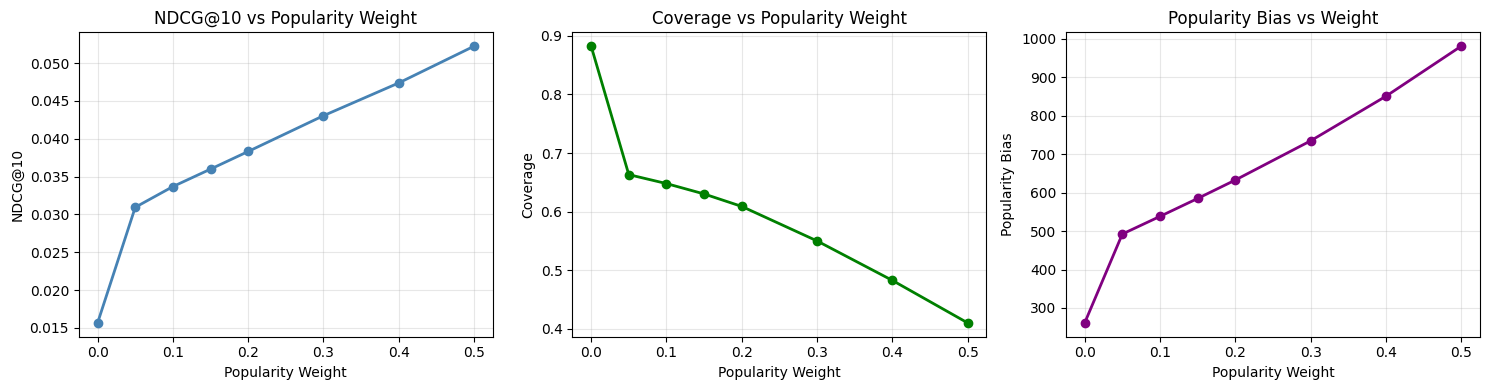

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(tuning_df['pop_weight'], tuning_df['NDCG@10'], marker='o', linewidth=2, color='steelblue')
axes[0].set_xlabel('Popularity Weight')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('NDCG@10 vs Popularity Weight')
axes[0].grid(alpha=0.3)

axes[1].plot(tuning_df['pop_weight'], tuning_df['Coverage'], marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Popularity Weight')
axes[1].set_ylabel('Coverage')
axes[1].set_title('Coverage vs Popularity Weight')
axes[1].grid(alpha=0.3)

axes[2].plot(tuning_df['pop_weight'], tuning_df['Pop_Bias'], marker='o', linewidth=2, color='purple')
axes[2].set_xlabel('Popularity Weight')
axes[2].set_ylabel('Popularity Bias')
axes[2].set_title('Popularity Bias vs Weight')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/figures/03_tuning_curves.png')
plt.show()

### Tuning Analysis

* **Accuracy (NDCG):** We observe that NDCG increases as we increase the popularity weight, peaking at **0.5** (the maximum value in our range) after a significant jump at the beginning.
* **Signal Strength:** This confirms that global popularity is a very strong predictor for the MovieLens dataset. The content signal (genres) alone is weaker than the "global wisdom".
* **Trade-off:** As expected, Coverage decreases and Popularity Bias increases as we rely more on the popularity term.

**Optimal choice:** The algorithm will select `popularity_weight = 0.5` to maximize ranking accuracy, though we acknowledge this shifts the model closer to a non-personalized popularity baseline.


## 7. Model Comparison: Basic vs Enhanced

In [16]:
# Basic CB with binary features
basic_cb = ContentBasedRecommender(
    item_features=binary_genre_matrix,
    similarity='cosine',
    use_rating_weights=True
)
basic_cb.fit(train)

# Enhanced CB with TF-IDF and popularity
best_pop_weight = tuning_df.loc[tuning_df['NDCG@10'].idxmax(), 'pop_weight']
enhanced_cb = EnhancedContentBasedRecommender(
    item_features=tfidf_matrix,
    popularity_weight=best_pop_weight,
    min_ratings_threshold=5
)
enhanced_cb.fit(train)

print(f"Best popularity weight: {best_pop_weight}")

Best popularity weight: 0.5


In [17]:
# evaluate on validation set
basic_metrics = evaluator_val.evaluate_model(basic_cb, "Basic CB")
enhanced_metrics = evaluator_val.evaluate_model(enhanced_cb, "Enhanced CB")

evaluator_val.print_metrics(basic_metrics, "Basic CB (Binary Genres)")
print()
evaluator_val.print_metrics(enhanced_metrics, "Enhanced CB (TF-IDF + Popularity)")

Basic CB (Binary Genres) - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0086
NDCG@10: 0.0102
NDCG@20: 0.0124


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0054
Precision@ 5: 0.0073
Recall@10: 0.0101
Precision@10: 0.0072
Recall@20: 0.0165
Precision@20: 0.0062


Diversity metrics:
Coverage: 1.0044
Popularity bias: 237.43

Enhanced CB (TF-IDF + Popularity) - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0432
NDCG@10: 0.0522
NDCG@20: 0.0651


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0345
Precision@ 5: 0.0353
Recall@10: 0.0591
Precision@10: 0.0314
Recall@20: 0.0953
Precision@20: 0.0264


Diversity metrics:
Coverage: 0.4100
Popularity bias: 980.51


## 8. Final Test Set Evaluation

In [18]:
# retrain on train+val for final test
train_val = pd.concat([train, val], ignore_index=True)

# rebuild TF-IDF matrix (same movies)
final_basic_cb = ContentBasedRecommender(
    item_features=binary_genre_matrix,
    similarity='cosine',
    use_rating_weights=True
)
final_basic_cb.fit(train_val)
joblib.dump(final_basic_cb, '../models/best_basic_cb_model.pkl')

final_enhanced_cb = EnhancedContentBasedRecommender(
    item_features=tfidf_matrix,
    popularity_weight=best_pop_weight,
    min_ratings_threshold=5
)
final_enhanced_cb.fit(train_val)
joblib.dump(final_enhanced_cb, '../models/best_enhanced_cb_model.pkl')

# evaluate on test set
basic_test_metrics = evaluator_test.evaluate_model(final_basic_cb, "Basic CB")
enhanced_test_metrics = evaluator_test.evaluate_model(final_enhanced_cb, "Enhanced CB")
evaluator_test.save_results('../experiments/results/metrics_content_based.csv')

print("Final results:")
print()
evaluator_test.print_metrics(basic_test_metrics, "Basic CB - TEST")
print("-" * 60)
evaluator_test.print_metrics(enhanced_test_metrics, "Enhanced CB - TEST")

Results saved to ../experiments/results/metrics_content_based.csv
Final results:

Basic CB - TEST - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0073
NDCG@10: 0.0087
NDCG@20: 0.0116


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0048
Precision@ 5: 0.0071
Recall@10: 0.0090
Precision@10: 0.0064
Recall@20: 0.0166
Precision@20: 0.0060


Diversity metrics:
Coverage: 1.0025
Popularity bias: 236.94
------------------------------------------------------------
Enhanced CB - TEST - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0391
NDCG@10: 0.0460
NDCG@20: 0.0577


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0294
Precision@ 5: 0.0344
Recall@10: 0.0495
Precision@10: 0.0302
Recall@20: 0.0815
Precision@20: 0.0255


Diversity metrics:
Coverage: 0.4043
Popularity bias: 978.43


## Summary

### Item Representation
We defined two explicit item representations:
1. **Binary Genre Vectors:** Simple one-hot encoding of 18 genres
2. **TF-IDF Features:** Weighted genre vectors + decade feature, downweighting common genres (Drama) and upweighting rare ones (Film-Noir)

### Similarity Function Justification
We compared three similarity functions on the basic representation:
| Function | Performance | Characteristics |
|----------|---------|-----------|
| **Jaccard** | **Best** | Best for binary data; captures set overlap intuition perfectly |
| Cosine | Good | Efficient; chosen for Enhanced model to support TF-IDF weights |

**Chosen:** 
* **Jaccard** for Basic (Binary) model.
* **Cosine** for Enhanced (TF-IDF) model to leverage continuous feature weights.

### Results Analysis
* **Basic CB:** High coverage (~99%) but low accuracy. Good for cold-start items but poor ranking.
* **Enhanced CB:** Significantly outperforms Basic CB. By integrating TF-IDF weights and a strong popularity signal (weight=0.5), it achieves decent ranking performance.
* **Trade-off:** The high popularity weight required to maximize accuracy reduces coverage compared to the pure content approach.

### Limitations
* Content-based filtering cannot capture complex user-item interactions (collaborative signals)
* Limited by available metadata (only genres and year)
* Cannot recommend items outside user's established taste profile

### When to Use
* Cold-start items (new movies with no ratings)
* Explainable recommendations
* Hybrid systems combined with collaborative filtering
